In [6]:
import pandas as pd
from collections import Counter
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
data_dir = "data/"
all_data = {}
for file in sorted(glob(data_dir + "*.csv")):
    df = pd.read_csv(file, index_col=0)
    all_data[file[13:-4]] = df
all_data

{'chain1':                    0       1       2       3       4       5       6       7  \
 initial         tape    mabi    dage  kipobo  ponebe    bude  pigoba  mupote   
 oliver          mape    mipe  godoba  tikami  ponebe    tipe    noko    niki   
 GPT5          bakupo    mipe    gupe    denu    miki    niki  tenaki    naku   
 Aimee           biku    biku    gupe    gupe  gakoku    niki    beto    niki   
 Hi            bikeka    babe    biko    bake    buke  bikuke    bika    baku   
 bl            babapo    dodo    pika  pimipo  pimipo  mikupo    miku  popopo   
 Ziqian          bapo  popopo    pika  bamipo    miku  mikupo    miku  mikupo   
 Tony          babapo  popopo    piku  pimika  bamiko  mikupo  mikupo  mipopo   
 Mingyang      bababu  bababu    pika  pikaku  mikuku  mikuku  mikuko  mikuku   
 Celinda Zhu   bababu  bababu    pika  mikuku    miku  mikuku  mikuku  mikuku   
 Ray W         mikuko  bababu  mikoki  momomo  mikuku  bababo  mukoku  bababo   
 Chengyuan Ma  bab

#### Less entropy over generations

In [19]:
def frequency_data(list_of_strings, length=1):
    '''
    frequency of substrings of length len in list_of_strings
    '''
    freq = Counter()
    for string in list_of_strings:
        freq.update([string[i:i+length] for i in range(0, len(string)-1, length % 2 + 2)])
    return freq

def calc_entropy(freq):
    '''
    entropy of a frequency distribution
    '''
    total = sum(freq.values())
    probs = [freq[key]/total for key in freq.keys()]
    return -sum([p*np.log2(p) for p in probs])

rows = []
for l in [1, 2, 4]:
    for file, data in all_data.items():
        i = 0
        for _, row in data.iterrows():
            freq = frequency_data(row, length=l)
            entropy = calc_entropy(freq)
            r = [file, i, l, entropy]
            rows.append(r)
            i += 1
freq_df = pd.DataFrame(rows, columns=["file", "iter", "length", "entropy"])
print(freq_df)

       file  iter  length   entropy
0    chain1     0       1  3.514215
1    chain1     1       1  3.157844
2    chain1     2       1  3.184830
3    chain1     3       1  2.679077
4    chain1     4       1  1.422668
..      ...   ...     ...       ...
103  chain3     7       4  3.952750
104  chain3     8       4  4.465696
105  chain3     9       4  3.640886
106  chain3    10       4  4.081450
107  chain3    11       4  4.071443

[108 rows x 4 columns]


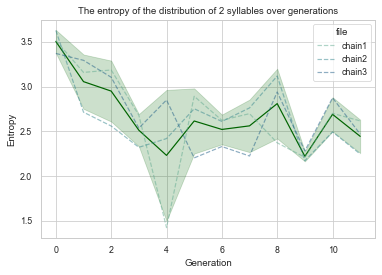

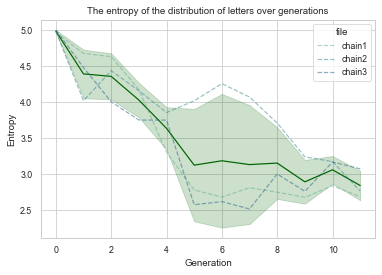

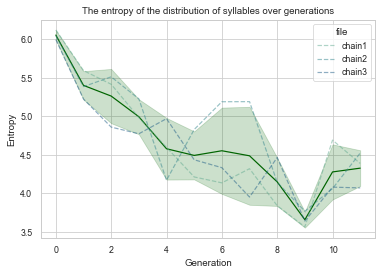

In [20]:
sns.set_style("whitegrid")
sns.set_context("paper")
name = ['The entropy of the distribution of ' + n + ' over generations' for n in ['letters', 'syllables', '2 syllables']]
for l in [1, 2, 4]:
    plt.figure()
    sns.lineplot(x="iter", y="entropy", data=freq_df[freq_df["length"]==l], markers=True, errorbar='sd', color='darkgreen')
    sns.lineplot(x="iter", y="entropy", hue="file", data=freq_df[freq_df["length"]==l], markers=True, linestyle='--', palette="crest", alpha=0.5)
    plt.xlabel("Generation")
    plt.ylabel("Entropy")
    plt.title(name[int(np.log2(l)-1)])
    plt.savefig(f'plots/freq_analysis_{l}.jpg', dpi=400)
    plt.show()

#### Individual color terms become more consistent over generations

In [21]:
#### distance metrics ####

def shared_number_of_syllables(word1, word2):
    '''
    number of syllables shared by two words
    '''
    syllables1 = [word1[i:i+2] for i in range(0, len(word1)-1, 2)]
    syllables2 = [word2[i:i+2] for i in range(0, len(word2)-1, 2)]
    shared = [min(syllables1.count(syllable), syllables2.count(syllable)) for syllable in set(syllables1)]
    return sum(shared)

def edit_distance(word1, word2):
    '''
    edit distance between two words
    '''
    if len(word1) > len(word2):
        word1, word2 = word2, word1
    distances = range(len(word1) + 1)
    for i2, c2 in enumerate(word2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(word1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [22]:
def differences_across_generation(col, distance_metric, kernel=[1]):
    diffs = []
    for i in range(len(kernel), len(col)):
        diff = 0
        for j in range(len(kernel)):
            diff += kernel[j] * distance_metric(col[i-j-1], col[i])
        diffs.append(diff / sum(kernel))
    return diffs

In [25]:
differences_across_generation(all_data['chain1']["0"], shared_number_of_syllables, kernel=[1])

[1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 3.0, 0.0, 0.0]

In [28]:
rows = []
columns = ["file", "color", "iter", "distance", "value"]
for data_n, data in all_data.items():
    for dist in [shared_number_of_syllables, edit_distance]:
        for col_n, col in data.items():
            diffs = differences_across_generation(col, dist, kernel=[1, 0.5, 0.25])
            for j in range(len(diffs)):
                r = [data_n, col_n, j, dist.__name__, diffs[j]]
                rows.append(r)
diff_df = pd.DataFrame(rows, columns=columns)
print(diff_df)

        file color  iter                    distance     value
0     chain1     0     0  shared_number_of_syllables  0.571429
1     chain1     0     1  shared_number_of_syllables  0.571429
2     chain1     0     2  shared_number_of_syllables  0.285714
3     chain1     0     3  shared_number_of_syllables  1.142857
4     chain1     0     4  shared_number_of_syllables  2.000000
...      ...   ...   ...                         ...       ...
1615  chain3    29     4               edit_distance  2.714286
1616  chain3    29     5               edit_distance  4.285714
1617  chain3    29     6               edit_distance  3.857143
1618  chain3    29     7               edit_distance  3.000000
1619  chain3    29     8               edit_distance  4.142857

[1620 rows x 5 columns]


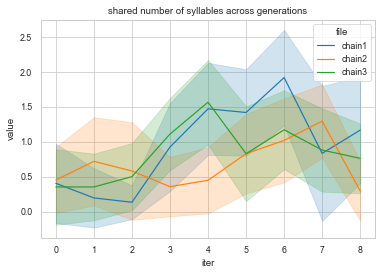

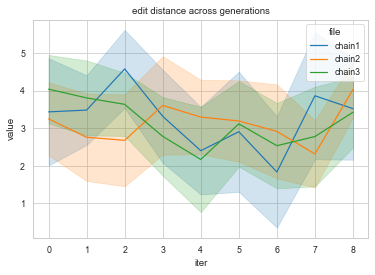

In [31]:
for dist in [shared_number_of_syllables, edit_distance]:
    plt.figure()
    sns.lineplot(x="iter", y="value", hue="file", data=diff_df[diff_df["distance"]==dist.__name__], markers=True, errorbar='sd')
    plt.title(f'{(dist.__name__).replace("_", " ")} across generations')
    plt.savefig(f'plots/{dist.__name__}.jpg', dpi=400)
    plt.show()